In [211]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, silhouette_samples, silhouette_score
import seaborn as sns
import numpy as np
from scipy.stats import multivariate_normal as mvn


# Preparing all the parameters and data

In [ ]:
'''
NUMBER OF PHONEMES:
sifir (1-660): 4
wahad (661-1320): 5
ithnayn (1321-1980): 5
thalatha (1981-2640): 6
araba'a (2641-3300): 6
khamsa (3301-3960): 5
sittah (3961-4620): 4
seb'a (4621-5280): 5
thamanieh (5281-5940): 7
tis'ah (5941-6600): 4
'''

In [61]:
train_data = pd.read_csv('Train_Arabic_Digit.txt', sep=" ", header=None)
train_data.columns = ["coeff1", "coeff2", "coeff3", "coeff4", "coeff5", "coeff6", "coeff7", "coeff8", "coeff9", "coeff10", "coeff11", "coeff12", "coeff13"]
train_data_breakdown = [1, 661, 1321, 1981, 2641, 3301, 3961, 4621, 5281, 5941]


test_data = pd.read_csv('Test_Arabic_Digit.txt', sep=" ", header=None)
test_data.columns = ["coeff1", "coeff2", "coeff3", "coeff4", "coeff5", "coeff6", "coeff7", "coeff8", "coeff9", "coeff10", "coeff11", "coeff12", "coeff13"]
test_data_breakdown = [1, 221, 441, 661, 881, 1101, 1321, 1541, 1761, 1981]


In [62]:
train_data["group_no"] = train_data.isnull().all(axis=1).cumsum()
d_train = {n: train_data.iloc[rows].dropna()
 for n, rows in train_data.groupby('group_no').groups.items()}

test_data["group_no"] = test_data.isnull().all(axis=1).cumsum()
d_test = {n: test_data.iloc[rows].dropna()
 for n, rows in test_data.groupby('group_no').groups.items()}

In [63]:
'''
training data structure (dict with key, value = digit, large digit df):
1. need to combine all training datasets for each digit (result in 10 large df)
2. remove all NaN
3. add to dictionary of key, value defined as digit, df_digit
'''
train_df_dict = {}
for d in range(10):
    start = train_data_breakdown[d]
    end = train_data_breakdown[d+1] if (d<9) else len(d_train)+1
    df = d_train[start]
    
    for i in range(start+1, end):
        df = df.append(d_train[i])
    df = df.reset_index()
    df = df.drop(columns=['index', 'group_no'])
    train_df_dict[d] = df

'''
testing data structure:
1. dict of all df's from splitting by NaN rows (just use d_test)
'''

"\ntesting data structure:\n1. dict of all df's from splitting by NaN rows (just use d_test)\n"

# Initial plotting of train data

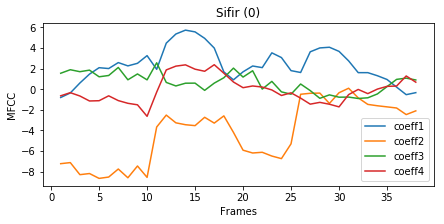

In [176]:
fig, ax = plt.subplots(figsize=(7,3))
ax.plot(d_train[1]["coeff1"])
ax.plot(d_train[1]["coeff2"])
ax.plot(d_train[1]["coeff3"])
ax.plot(d_train[1]["coeff4"])
ax.set_title("Sifir (0)")
ax.set_xlabel("Frames")
ax.set_ylabel("MFCC")
ax.legend()
fig.savefig("sifir_mfcc_frame")

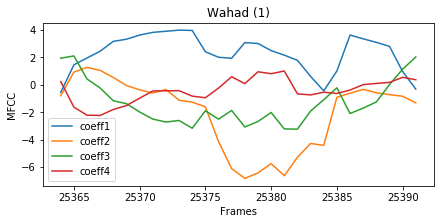

In [179]:
fig, ax = plt.subplots(figsize=(7,3))
ax.plot(d_train[700]["coeff1"])
ax.plot(d_train[700]["coeff2"])
ax.plot(d_train[700]["coeff3"])
ax.plot(d_train[700]["coeff4"])
ax.set_title("Wahad (1)")
ax.set_xlabel("Frames")
ax.set_ylabel("MFCC")
ax.legend()
fig.savefig("wahad_mfcc_frames")

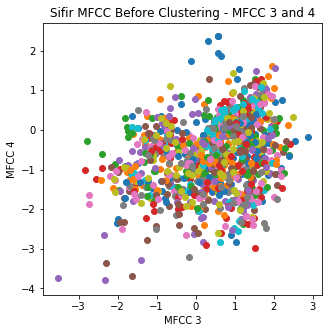

In [182]:
fig, ax = plt.subplots(figsize=(5,5))

for i in range(1, 30):
    ax.scatter(d_train[i]["coeff3"], d_train[i]["coeff4"])
ax.set_title("Sifir MFCC Before Clustering - MFCC 3 and 4")
ax.set_xlabel("MFCC 3")
ax.set_ylabel("MFCC 4")
fig.savefig("precluster_sifir_3_4")

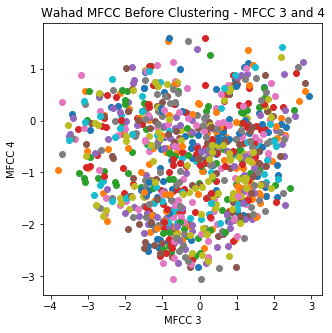

In [185]:
fig, ax = plt.subplots(figsize=(5,5))

for i in range(701, 730):
    ax.scatter(d_train[i]["coeff3"], d_train[i]["coeff4"])
    
ax.set_title("Wahad MFCC Before Clustering - MFCC 3 and 4")
ax.set_xlabel("MFCC 3")
ax.set_ylabel("MFCC 4")
fig.savefig("precluster_wahad_3_4")

# Modeling and Maximum Likelihood with K-Means

In [ ]:
'''
K-MEANS CLUSTERING (Multi-dimensional)
clusters should range from number of phonemes to 2*phonemes-1

NUMBER OF PHONEMES:
sifir (1-660): 4
wahad (661-1320): 5
ithnayn (1321-1980): 5
thalatha (1981-2640): 6
araba'a (2641-3300): 6
khamsa (3301-3960): 5
sittah (3961-4620): 4
seb'a (4621-5280): 5
thamanieh (5281-5940): 7
tis'ah (5941-6600): 4

'''

phonemes = [4,5,5,6,6,5,4,5,7,4]

## Derivation of GMM Distribution with K-means

In [186]:
'''
Use a scree/elbow plot of the distortions to determine what number of clusters is best for each digit. 
This will be done visually and the number of clusters will be chosed at the point of diminishing return.
From the optimization of number of coefficients with the use of the minimum (# phonemes) clusters used as a baseline,
I obtained that the use of 11 MFCC as features resulted in the best performing models for classification, so I will 
be using datasets with 11 MFCC here to determine the number of clusters with scree plots.
'''

'\nUse a scree/elbow plot of the distortions to determine what number of clusters is best for each digit. \nThis will be done visually and the number of clusters will be chosed at the point of diminishing return.\nFrom the optimization of number of coefficients with the use of the minimum (# phonemes) clusters used as a baseline,\nI obtained that the use of 11 MFCC as features resulted in the best performing models for classification, so I will \nbe using datasets with 11 MFCC here to determine the number of clusters with scree plots.\n'

In [192]:
new_train_dict = train_df_dict.copy()
red_cols = data_columns[:11]
for i in new_train_dict.keys():
    df = new_train_dict[i]
    new_train_dict[i] = df[df.columns[df.columns.isin(red_cols)]]

distortions = {}
for d in range(10):
    phon = phonemes[d]
    dist = []
    for k in range(1,2*phon):
        train_df = new_train_dict[d]
        kmeanModel = KMeans(n_clusters=k)
        kmeanModel.fit(train_df)
        dist.append(kmeanModel.inertia_)
    distortions[d] = dist

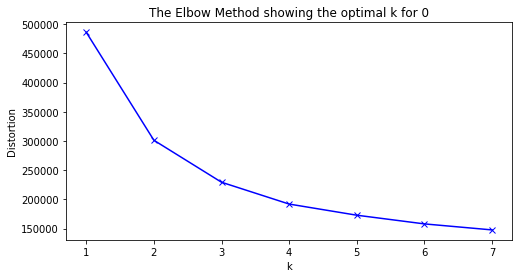

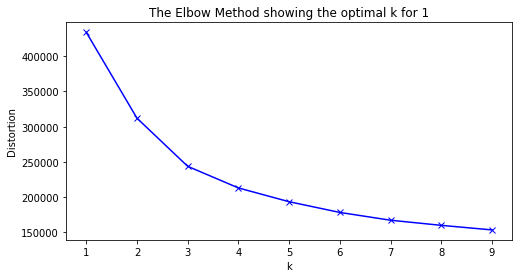

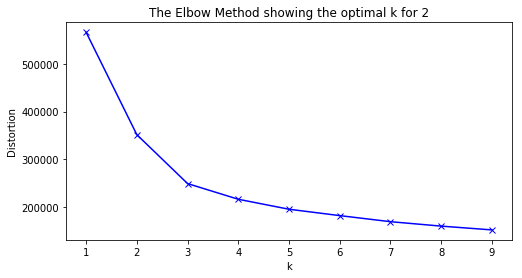

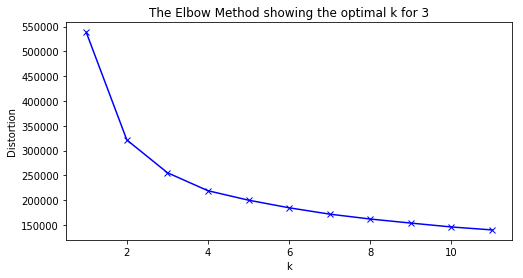

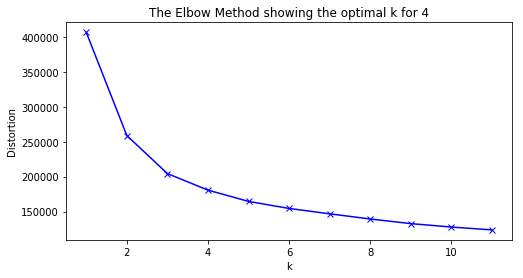

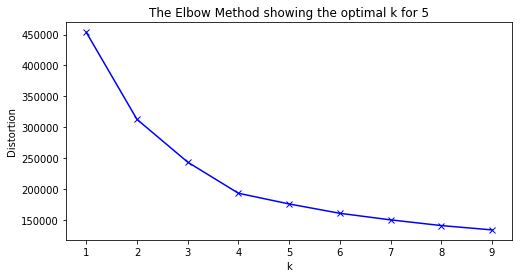

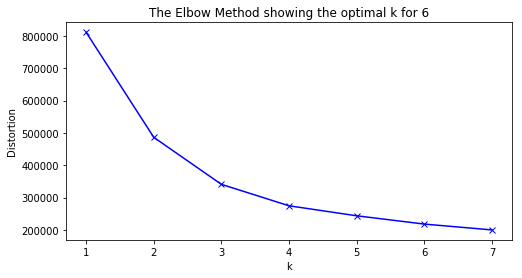

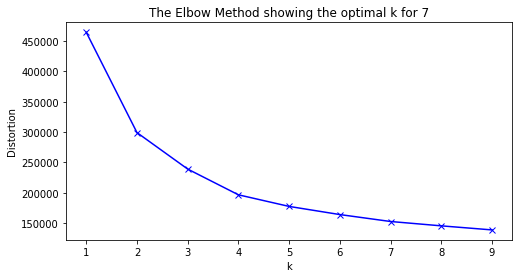

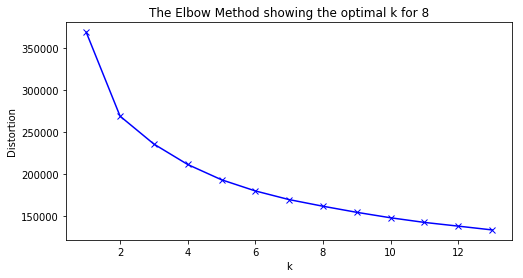

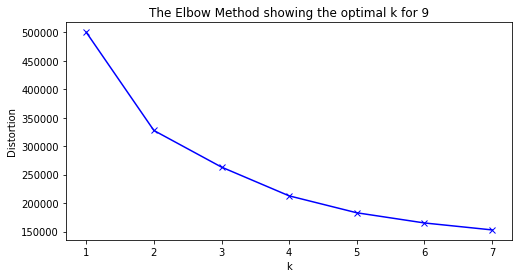

In [195]:
for d in range(10):
    data_plot = distortions[d]
    phon = phonemes[d]
    plt.figure(figsize=(8,4))
    plt.plot(range(1,2*phon), data_plot, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    title = 'The Elbow Method showing the optimal k for '+str(d)
    plt.title(title)
    fname = 'scree_kmeans_'+str(d)
    plt.savefig(fname)
    plt.show()

In [197]:
'''
DEFINING THE NUMBER OF CLUSTERS TO USE FOR KMEANS BASED ON SCREE PLOTS ABOVE

sifir (1-660): 4
wahad (661-1320): 5
ithnayn (1321-1980): 5
thalatha (1981-2640): 6
araba'a (2641-3300): 6
khamsa (3301-3960): 5
sittah (3961-4620): 4
seb'a (4621-5280): 5
thamanieh (5281-5940): 9
tis'ah (5941-6600): 4
'''
clusters_km = [4, 5, 5, 6, 6, 5, 4, 5, 9, 4]


In [251]:
class KM_GMMDigits:
    '''
    https://towardsdatascience.com/k-means-clustering-with-scikit-learn-6b47a369a83c
    ^ example code for scree/elbow plots to determine number of clusters
    '''
    def __init__(self, clusters, df_digits):
        self.digits = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
        self.clusters = clusters
        self.df_digits_train = df_digits
        self.digit_gmm = {}
    
    def all_kmeans(self):
        for d in self.digits:
            num_clusters = self.clusters[d]
            df = self.df_digits_train[d].copy()
            kmeans = KMeans(n_clusters=num_clusters)
            kmeans.fit(df)
            df['cluster'] = kmeans.labels_
            
            #plotting clusters
            title = "K-Means MCCF1 v MCCF2 clusters for "+str(d)
            fig, ax = plt.subplots(figsize=(8,5))
            ax.scatter(data=df, x='coeff1', y='coeff2', c='cluster', cmap='Set3')
            ax.set(title=title, xlabel='Coeff1', ylabel='Coeff2')
            fig.savefig(title)
            plt.show()
            
            grouped = df.groupby(df.cluster)
            df_clusters = {}

            for i in df.cluster.unique():
                df_clusters[i] = grouped.get_group(i).drop(columns=['cluster'])

            cov = {}
            mean = {}
            weight = {}
            for i in df_clusters.keys():
                cov[i] = np.cov(df_clusters[i].values.T)
                mean[i] = np.mean(df_clusters[i].values, 0)
                weight[i] = len(df_clusters[i].values)/len(df)
            self.digit_gmm[d] = {"weights": weight, "means": mean, "covariances": cov}
        return self.digit_gmm

        
class DigitClassifierKM:     
    def __init__(self, test, km):
        self.digits = km.digits
        self.clusters = km.clusters
        self.all_km = km.digit_gmm
        self.df_test = test
        self.digit_likelihoods = []
        
    def likelihood_calc(self):
        for d in self.digits:
            likelihood = 0
            # get the GMM model for the specific digit
            gmm = self.all_km[d]
            gmm_weights = gmm["weights"]
            gmm_means = gmm["means"]
            gmm_covs = gmm["covariances"]
            for index, frame in self.df_test.iterrows():

                # running sum for all the weighted likelihoods for each component within the GMM distribution
                running_sum = 0
                for i in range(self.clusters[d]):
                    mean = gmm_means[i]
                    cov = gmm_covs[i]
                    weight = gmm_weights[i]

                    # calculation of the weight*pdf
                    running_sum += weight * mvn.pdf(frame, mean, cov)

                # running product of the likelihoods for each of the frames
                likelihood += np.log(running_sum)

            # final likelihood value of that digit for specified dataset
            self.digit_likelihoods.append(np.exp(likelihood))
        
    def predict(self):
        self.likelihood_calc()
        return np.argmax(self.digit_likelihoods)
    
class ClassifierScorerKM:
    def __init__(self, test, test_breakdown, gmmdigits):
        self.digits = gmmdigits.digits
        self.all_gmm = gmmdigits.digit_gmm
        self.gmmdigits = gmmdigits
        self.df_test = test
        self.test_breakdown = test_breakdown
        self.digit_scores = {}
        self.all_predictions = []
        self.all_expected = []
        self.all_accuracies = {}
        
    def all_predictions_calc(self):
        for d in self.digits:
            predictions = []
            start = self.test_breakdown[d]
            end = self.test_breakdown[d+1] if (d<9) else len(self.df_test)+1
            for i in range(start, end):
                df = self.df_test[i]
                df = df.reset_index()
                df = df.drop(columns=['index'])
                classifier = DigitClassifierKM(df, self.gmmdigits)
                prediction = classifier.predict()
                predictions.append(prediction)
            self.all_predictions.append(predictions)
            
    def all_expected_calc(self):
        for d in self.digits:
            start = self.test_breakdown[d]
            end = self.test_breakdown[d+1] if (d<9) else len(self.df_test)+1
            expected = [d]*(end-start)
            self.all_expected.append(expected)
            
    def get_predictions(self):
        print(np.array(self.all_predictions).flatten())
        
    def get_expected(self):
        print(np.array(self.all_expected).flatten())
        
    def get_model_accuracies(self):
        accuracies = []
        for d in range(10):
            predictions = np.array(self.all_predictions[d])
            correct = predictions[predictions==d]
            accuracies.append(len(correct)/len(predictions))
        self.all_accuracies[len(self.df_test[1].columns)] = accuracies
        return self.all_accuracies
                
    def confusion_mat(self, num_coeffs):
        file_title = "confusion_mat_gmm_km_"+str(num_coeffs)+'cepstral_coeffs'
        plot_title = "KM Confusion Matrix for " + str(num_coeffs) + " Cepstral Coefficients"
        cm = confusion_matrix(np.array(self.all_expected).flatten(), np.array(self.all_predictions).flatten())
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()
        plt.title("KM Confusion Matrix")
        plt.savefig(file_title)
        plt.show()
        

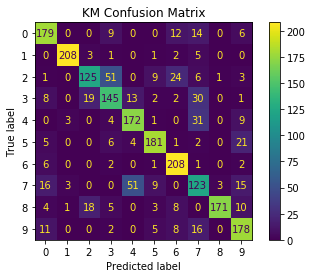

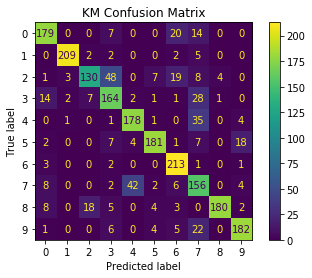

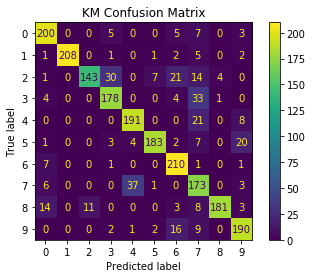

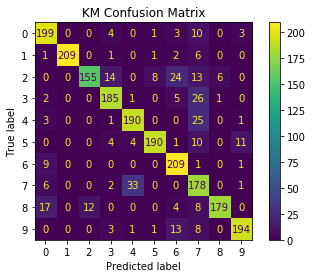

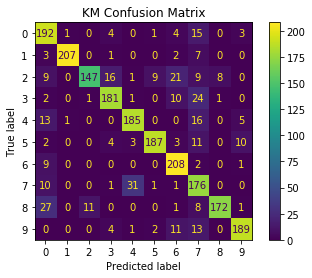

{5: [0.8136363636363636, 0.9454545454545454, 0.5681818181818182, 0.6590909090909091, 0.7818181818181819, 0.8227272727272728, 0.9454545454545454, 0.5590909090909091, 0.7772727272727272, 0.8090909090909091], 7: [0.8136363636363636, 0.95, 0.5909090909090909, 0.7454545454545455, 0.8090909090909091, 0.8227272727272728, 0.9681818181818181, 0.7090909090909091, 0.8181818181818182, 0.8272727272727273], 9: [0.9090909090909091, 0.9454545454545454, 0.65, 0.8090909090909091, 0.8681818181818182, 0.8318181818181818, 0.9545454545454546, 0.7863636363636364, 0.8227272727272728, 0.8636363636363636], 11: [0.9045454545454545, 0.95, 0.7045454545454546, 0.8409090909090909, 0.8636363636363636, 0.8636363636363636, 0.95, 0.8090909090909091, 0.8136363636363636, 0.8818181818181818], 13: [0.8727272727272727, 0.9409090909090909, 0.6681818181818182, 0.8227272727272728, 0.8409090909090909, 0.85, 0.9454545454545454, 0.8, 0.7818181818181819, 0.8590909090909091]}


In [157]:
'''
OPTIMIZATION OF THE NUMBER OF MFCC'S TO INCLUDE IN TRAIN AND TEST DATASETS FOR MODELING
'''

data_columns = ["coeff1", "coeff2", "coeff3", "coeff4", "coeff5", "coeff6", "coeff7", "coeff8", 
                    "coeff9", "coeff10", "coeff11", "coeff12", "coeff13"]
all_coeff_accuracies = {}

for coeffs in range(5,14,2):
    new_train_dict = train_df_dict.copy()
    new_test_dict = d_test.copy()
    red_cols = data_columns[:coeffs]
    for i in new_train_dict.keys():
        df = new_train_dict[i]
        new_train_dict[i] = df[df.columns[df.columns.isin(red_cols)]]
    for i in new_test_dict.keys():
        df = new_test_dict[i]
        new_test_dict[i] = df[df.columns[df.columns.isin(red_cols)]]

    phonemes = [4,5,5,6,6,5,4,5,7,4]  #using the number of phonemes as cluster count for baseline
    gmms = KM_GMMDigits(phonemes, new_train_dict)
    gmms.all_kmeans()
    classifier = ClassifierScorerKM(new_test_dict, test_data_breakdown, gmms)
    classifier.all_expected_calc()
    classifier.all_predictions_calc()
    dict_accuracy = classifier.get_model_accuracies()
    all_coeff_accuracies.update(dict_accuracy)
    classifier.confusion_mat(coeffs)
    
print(all_coeff_accuracies)

In [159]:
df_km_accuracies = pd.DataFrame.from_dict(all_coeff_accuracies, orient='index')
df_km_accuracies

,0,1,2,3,4,5,6,7,8,9
5,0.813636,0.945455,0.568182,0.659091,0.781818,0.822727,0.945455,0.559091,0.777273,0.809091
7,0.813636,0.950000,0.590909,0.745455,0.809091,0.822727,0.968182,0.709091,0.818182,0.827273
9,0.909091,0.945455,0.650000,0.809091,0.868182,0.831818,0.954545,0.786364,0.822727,0.863636
11,0.904545,0.950000,0.704545,0.840909,0.863636,0.863636,0.950000,0.809091,0.813636,0.881818
13,0.872727,0.940909,0.668182,0.822727,0.840909,0.850000,0.945455,0.800000,0.781818,0.859091


# Derivation of GMM Distribution with EM

For n_clusters = 4 The average silhouette_score is : 0.15114308312914165


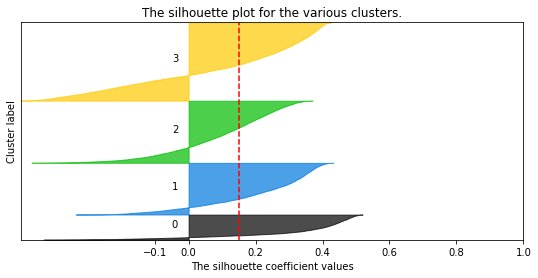

For n_clusters = 5 The average silhouette_score is : 0.13554333599304486


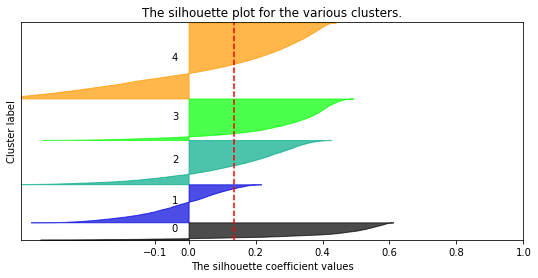

For n_clusters = 6 The average silhouette_score is : 0.12617275903830327


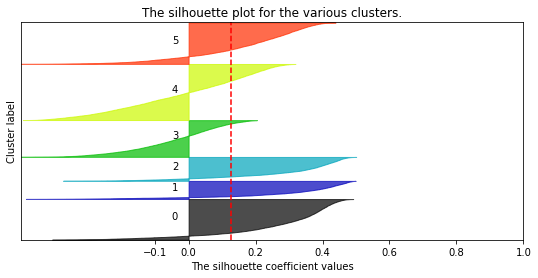

For n_clusters = 7 The average silhouette_score is : 0.12142736229503126


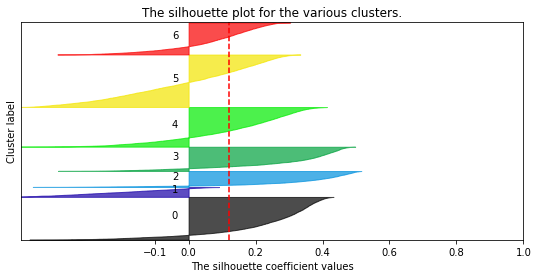

For n_clusters = 5 The average silhouette_score is : 0.1431065797303518


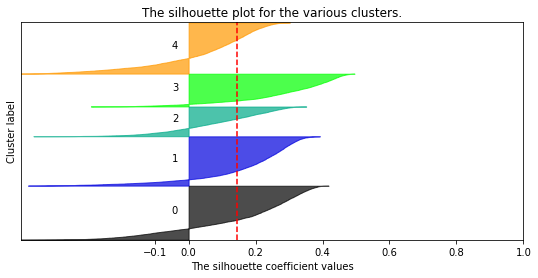

For n_clusters = 6 The average silhouette_score is : 0.1444307552563649


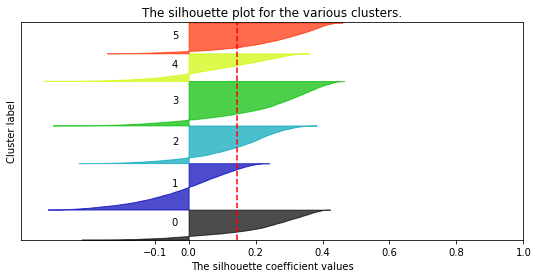

For n_clusters = 7 The average silhouette_score is : 0.13907473728505954


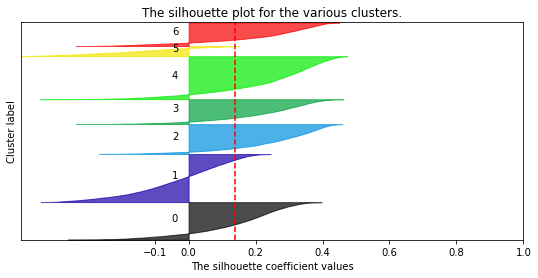

For n_clusters = 8 The average silhouette_score is : 0.11733299897178458


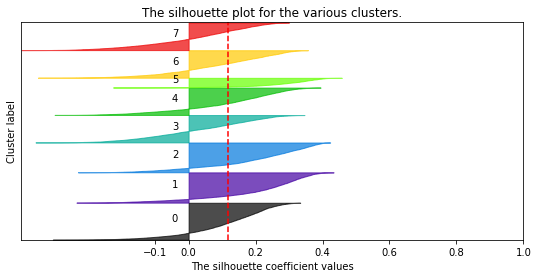

For n_clusters = 9 The average silhouette_score is : 0.10298348648047807


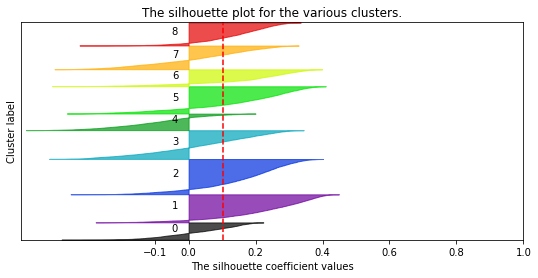

For n_clusters = 5 The average silhouette_score is : 0.16280225746340277


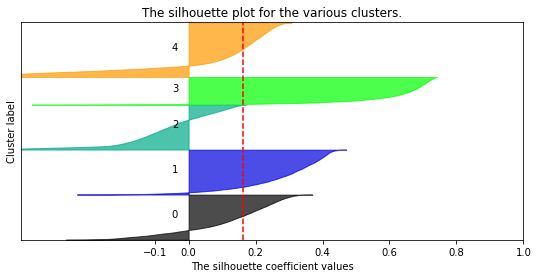

For n_clusters = 6 The average silhouette_score is : 0.17896605935318005


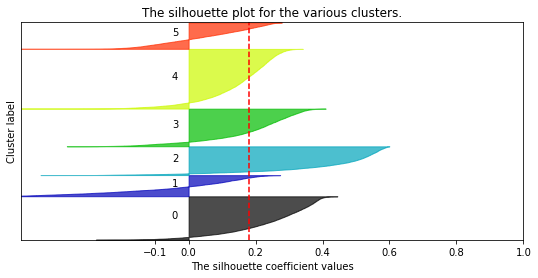

For n_clusters = 7 The average silhouette_score is : 0.14773022224455065


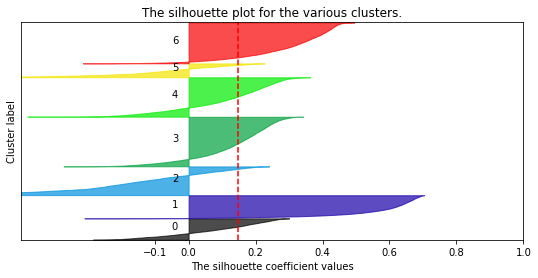

For n_clusters = 8 The average silhouette_score is : 0.13593705468949405


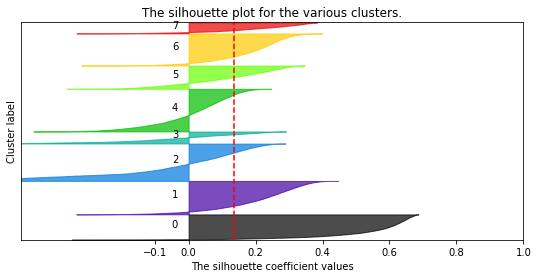

For n_clusters = 9 The average silhouette_score is : 0.12655118547209482


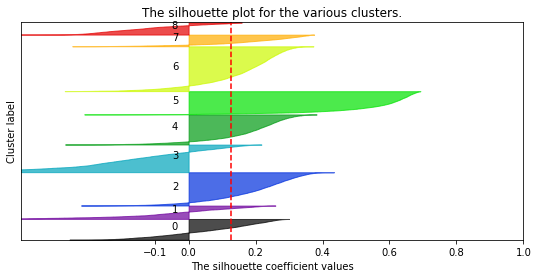

For n_clusters = 6 The average silhouette_score is : 0.11019161595757027


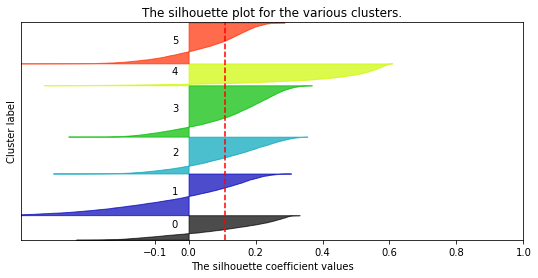

For n_clusters = 7 The average silhouette_score is : 0.11638508968811927


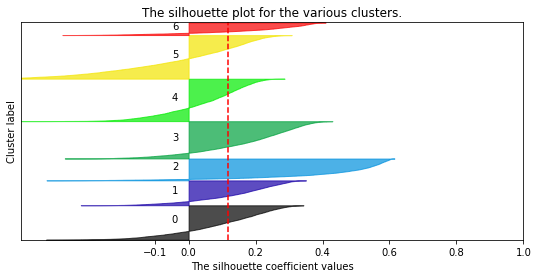

For n_clusters = 8 The average silhouette_score is : 0.10000944651497516


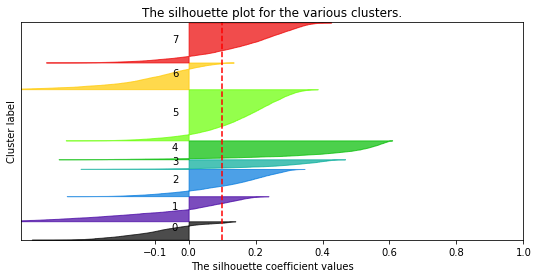

For n_clusters = 9 The average silhouette_score is : 0.11199567484884089


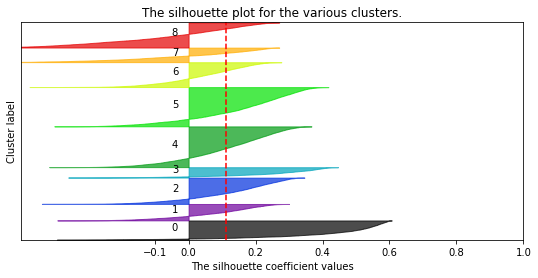

For n_clusters = 10 The average silhouette_score is : 0.12118644112925914


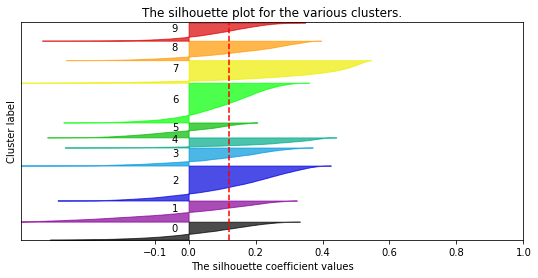

For n_clusters = 11 The average silhouette_score is : 0.0992779999108602


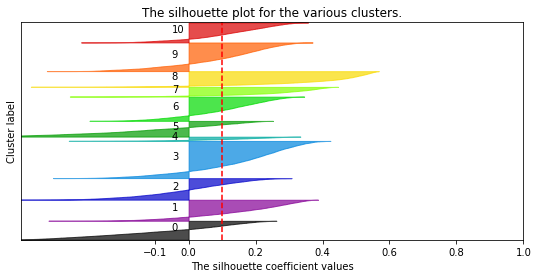

For n_clusters = 6 The average silhouette_score is : 0.09106955720719657


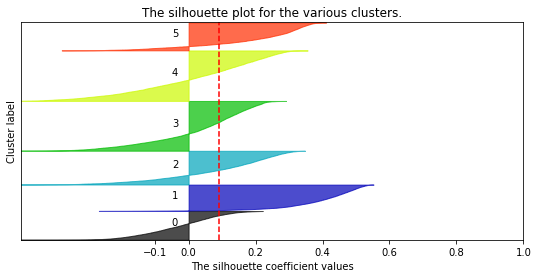

For n_clusters = 7 The average silhouette_score is : 0.05591357878623189


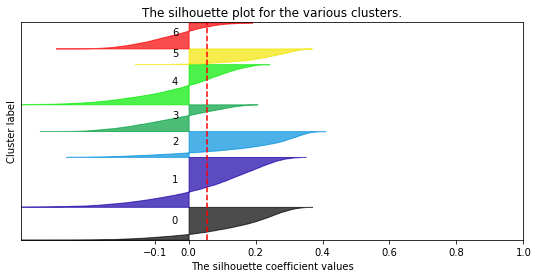

For n_clusters = 8 The average silhouette_score is : 0.07223666166486549


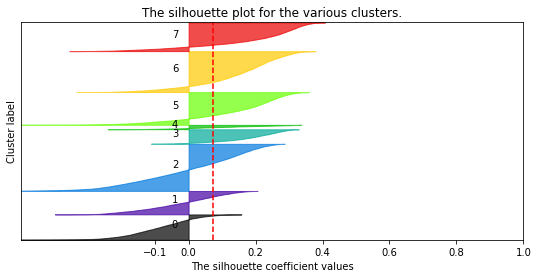

For n_clusters = 9 The average silhouette_score is : 0.04664871642278897


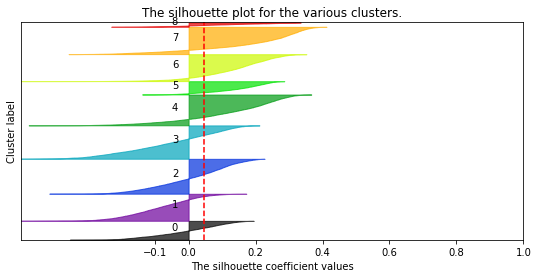

For n_clusters = 10 The average silhouette_score is : 0.05115670602689571


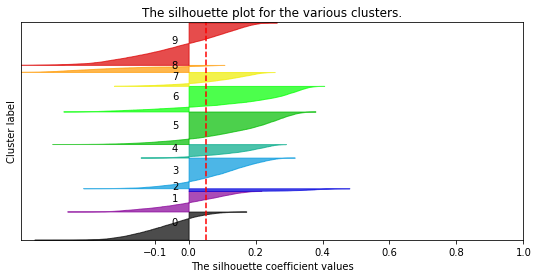

For n_clusters = 11 The average silhouette_score is : 0.04324813508956155


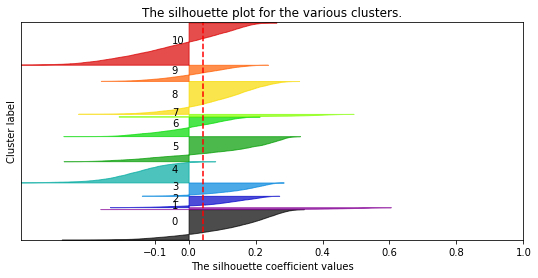

For n_clusters = 5 The average silhouette_score is : 0.11633634251635135


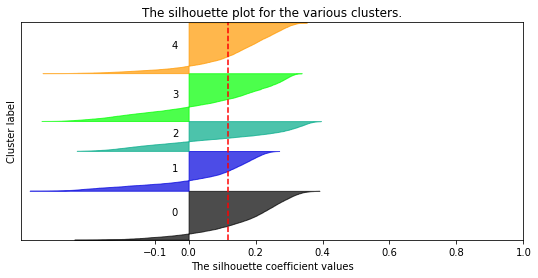

For n_clusters = 6 The average silhouette_score is : 0.11026283038573975


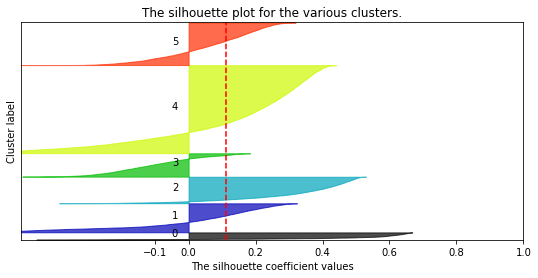

For n_clusters = 7 The average silhouette_score is : 0.08495255842371313


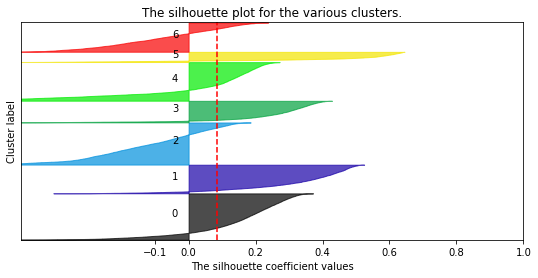

For n_clusters = 8 The average silhouette_score is : 0.08577434014288265


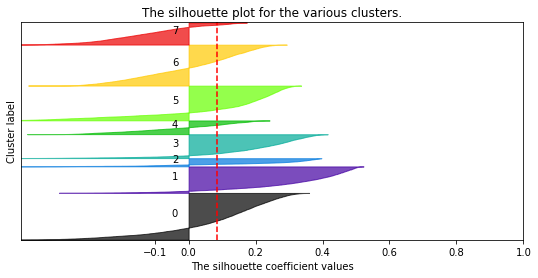

For n_clusters = 9 The average silhouette_score is : 0.0856815568513703


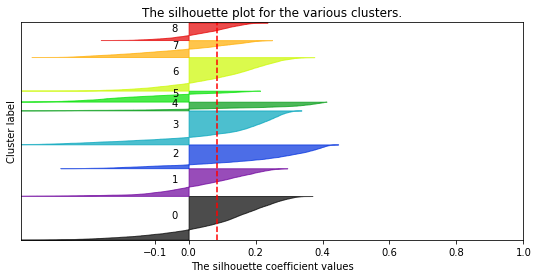

For n_clusters = 4 The average silhouette_score is : 0.30928130612219107


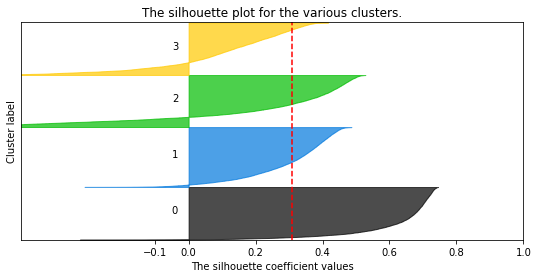

For n_clusters = 5 The average silhouette_score is : 0.20914005327688093


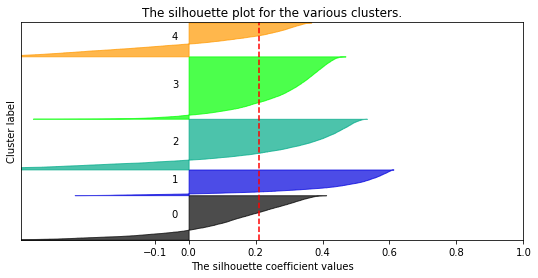

For n_clusters = 6 The average silhouette_score is : 0.18304011105892856


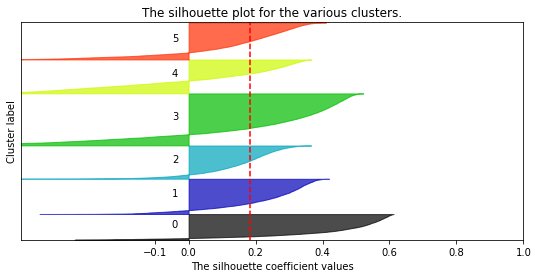

For n_clusters = 7 The average silhouette_score is : 0.16280945328038493


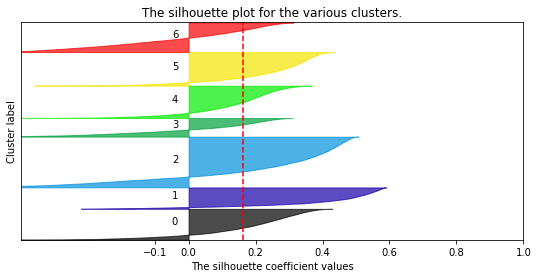

For n_clusters = 5 The average silhouette_score is : 0.15446549502180024


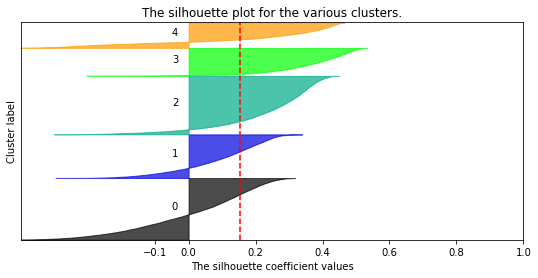

For n_clusters = 6 The average silhouette_score is : 0.13086153167032213


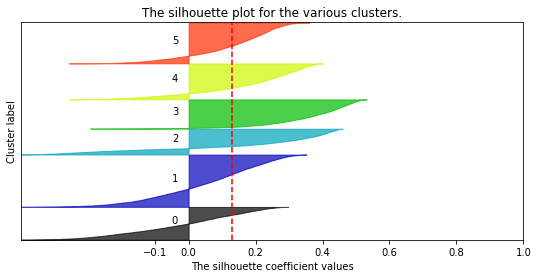

For n_clusters = 7 The average silhouette_score is : 0.11913804074051884


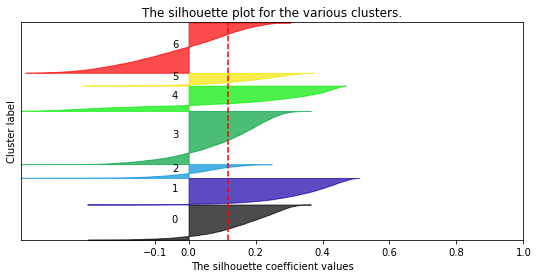

For n_clusters = 8 The average silhouette_score is : 0.0887275336361446


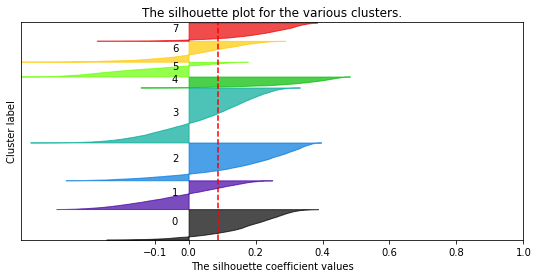

For n_clusters = 9 The average silhouette_score is : 0.07472344686979616


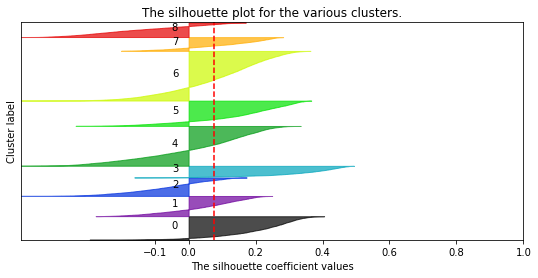

For n_clusters = 7 The average silhouette_score is : 0.038183609159509135


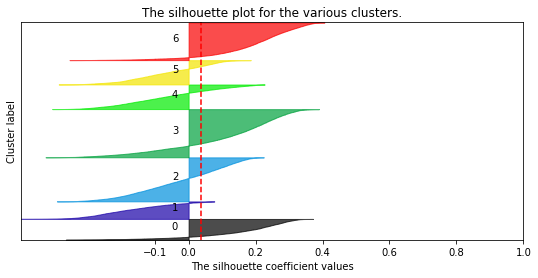

For n_clusters = 8 The average silhouette_score is : 0.06673394892057788


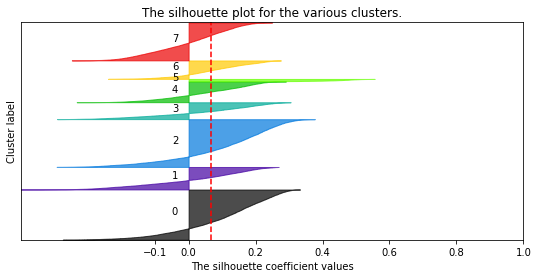

For n_clusters = 9 The average silhouette_score is : 0.04356631901307573


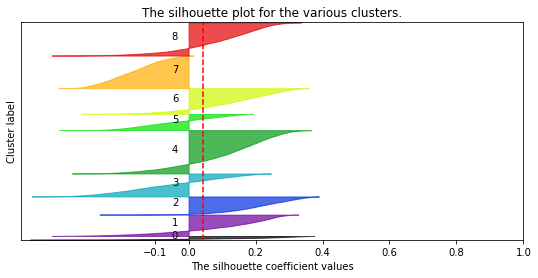

For n_clusters = 10 The average silhouette_score is : 0.04100004152520046


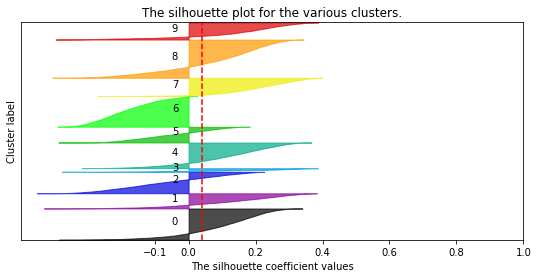

For n_clusters = 11 The average silhouette_score is : 0.030556019426964384


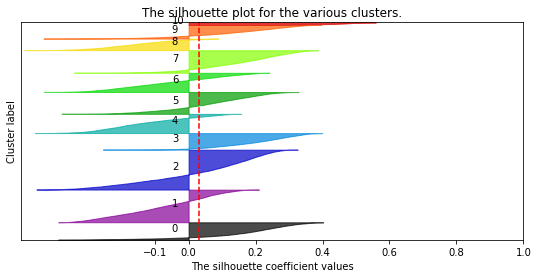

For n_clusters = 12 The average silhouette_score is : 0.03539141072685352


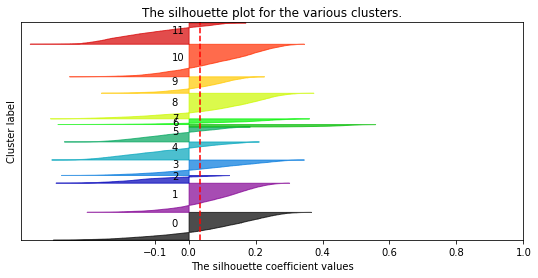

For n_clusters = 13 The average silhouette_score is : 0.01769914448017329


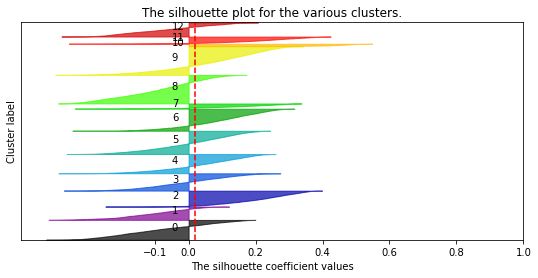

For n_clusters = 4 The average silhouette_score is : 0.21304523976302325


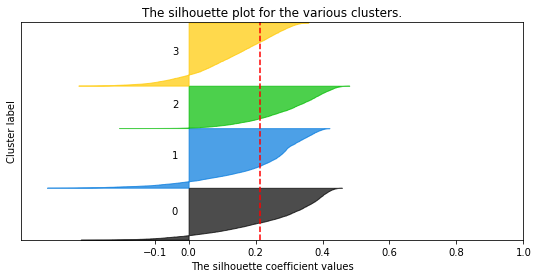

For n_clusters = 5 The average silhouette_score is : 0.18252758871053598


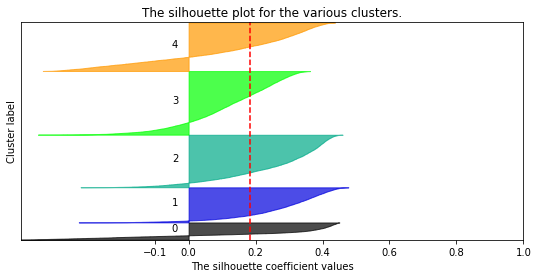

For n_clusters = 6 The average silhouette_score is : 0.1439215580717365


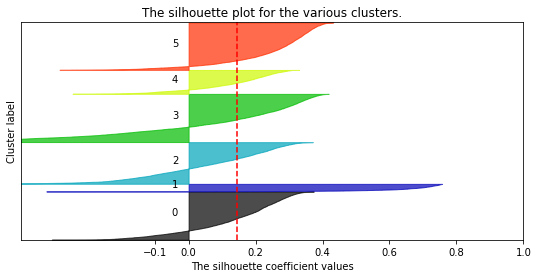

For n_clusters = 7 The average silhouette_score is : 0.12546185640921842


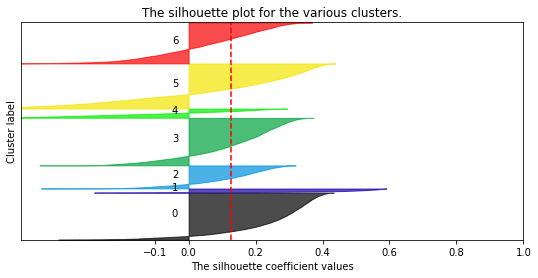

In [221]:
'''
determining the number of clusters for each digit using silhouette analysis

clusters = {4, 6, 6, 8, 6, 5, 4, 5, 8, 4}
'''

phonemes = [4,5,5,6,6,5,4,5,7,4]
all_sil_coeffs = {}

for d in range(10):
    
    X = new_train_dict[d]
    digit_sil_coefs = {}
    
    for n_clusters in range(phonemes[d], 2*phonemes[d]):
        # Create a subplot with 1 row and 2 columns
        fig, ax1 = plt.subplots()
        fig.set_size_inches(9,4)
        ax1.set_xlim([-0.5, 0.8])
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value
        clusterer = GaussianMixture(n_components=n_clusters)
        clusterer.fit(X)
        cluster_labels=clusterer.predict(X)
        cluster_labels.shape

        # The silhouette_score gives the average value for all the samples.
        silhouette_avg = silhouette_score(X, cluster_labels)
        digit_sil_coefs[n_clusters] = silhouette_avg
        
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(
                np.arange(y_lower, y_upper),
                0,
                ith_cluster_silhouette_values,
                facecolor=color,
                edgecolor=color,
                alpha=0.7,
            )

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10 
        title = "The silhouette plot for the various clusters - '"+str(d)+"', "+str(n_clusters)+" clusters"
        ax1.set_title(title)
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        plt.show()
        
    all_sil_coeffs[d] = digit_sil_coefs

In [226]:
df_all_sil_coeffs = pd.DataFrame.from_dict(all_sil_coeffs, orient="index")
df_all_sil_coeffs["max_cluster"] = df_all_sil_coeffs.idxmax(axis=1)
df_all_sil_coeffs.to_csv("silhouette_cluster_em")
clusters_em = np.array(df_all_sil_coeffs['max_cluster'])

In [246]:
class EM_GMMDigits:
    def __init__(self, clusters, df_digits):
        self.digits = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
        self.clusters = clusters
        self.df_digits_train = df_digits
        self.digit_gmm = {}
        
    def all_gmm(self):
        for d in self.digits:
            num_clusters = self.clusters[d]
            df = self.df_digits_train[d]
            self.digit_gmm[d] = GaussianMixture(n_components=num_clusters).fit(df)
        return self.digit_gmm
            
    def get_gmm(self):
        print(self.digit_gmm)

# Maximum Likelihood Classification from GMM

In [77]:
"""
for each of the digit GMM distributions:
    for each of the distributions that makes up the mixture model:
        - go through each of the frames and look at all the coefficients for that 
        - see likelihood of that frame for that distribution * the weight of the distribution
            - take the sum of all of these probabilities
        - take product of all the GMM distribution values for each frame
"""

'\nfor each of the digit GMM distributions:\n    for each of the distributions that makes up the mixture model:\n        - go through each of the frames and look at all the coefficients for that \n        - see likelihood of that frame for that distribution * the weight of the distribution\n            - take the sum of all of these probabilities\n        - take product of all the GMM distribution values for each frame\n'

In [166]:
class DigitClassifier:
    def __init__(self, test, gmm):
        self.digits = gmm.digits
        self.clusters = gmm.clusters
        self.all_gmm = gmm.digit_gmm
        self.df_test = test
        self.digit_likelihoods = []
        
    def likelihood_calc(self):
        for d in self.digits:
            # get the GMM model for the specific digit
            gmm = self.all_gmm[d]
            self.digit_likelihoods.append(np.exp(gmm.score(self.df_test)))
        
    def predict(self):
        self.likelihood_calc()
        return np.argmax(self.digit_likelihoods)

class ClassifierScorer:
    def __init__(self, test, test_breakdown, gmmdigits):
        self.digits = gmmdigits.digits
        self.all_gmm = gmmdigits.digit_gmm
        self.gmmdigits = gmmdigits
        self.df_test = test
        self.test_breakdown = test_breakdown
        self.digit_scores = {}
        self.all_predictions = []
        self.all_expected = []
        self.all_accuracies = {}
        
    def all_predictions_calc(self):
        for d in self.digits:
            predictions = []
            start = self.test_breakdown[d]
            end = self.test_breakdown[d+1] if (d<9) else len(self.df_test)+1
            gmm = self.all_gmm[d]
            for i in range(start, end):
                df = self.df_test[i]
                df = df.reset_index()
                df = df.drop(columns=['index'])
                classifier = DigitClassifier(df, self.gmmdigits)
                prediction = classifier.predict()
                predictions.append(prediction)
            self.all_predictions.append(predictions)
            
    def all_expected_calc(self):
        for d in self.digits:
            start = self.test_breakdown[d]
            end = self.test_breakdown[d+1] if (d<9) else len(self.df_test)+1
            expected = [d]*(end-start)
            self.all_expected.append(expected)
            
    def get_predictions(self):
        print(np.array(self.all_predictions).flatten())
        
    def get_expected(self):
        print(np.array(self.all_expected).flatten())
        
    def get_model_accuracies(self):
        accuracies = []
        for d in range(10):
            predictions = np.array(self.all_predictions[d])
            correct = predictions[predictions==d]
            accuracies.append(len(correct)/len(predictions))
        self.all_accuracies[len(self.df_test[1].columns)] = accuracies
        return self.all_accuracies
                
    def confusion_mat(self, num_coeffs):
        file_title = "confusion_mat_gmm_em_"+str(num_coeffs)+'cepstral_coeffs'
        plot_title = "EM Confusion Matrix for " + str(num_coeffs) + " Cepstral Coefficients"
        cm = confusion_matrix(np.array(self.all_expected).flatten(), np.array(self.all_predictions).flatten())
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()
        plt.title(plot_title)
        plt.savefig(file_title)
        plt.show()

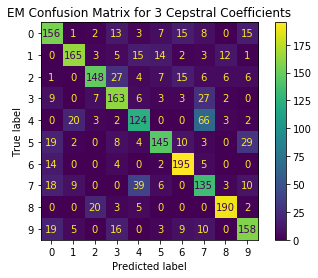

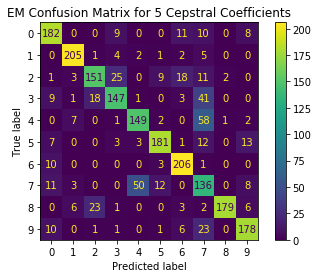

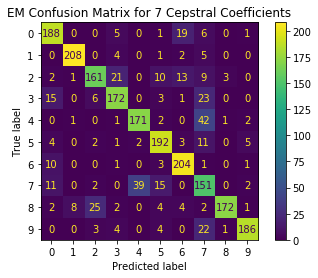

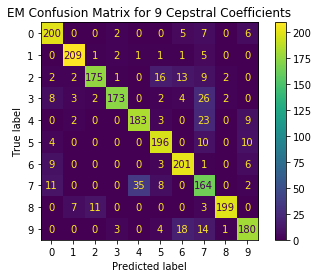

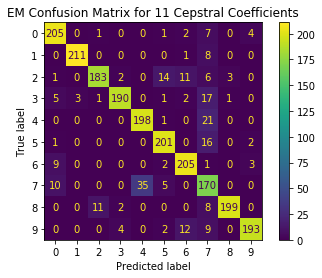

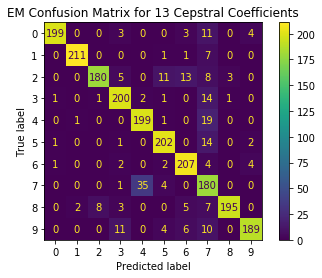

{3: [0.7090909090909091, 0.75, 0.6727272727272727, 0.740909090909091, 0.5636363636363636, 0.6590909090909091, 0.8863636363636364, 0.6136363636363636, 0.8636363636363636, 0.7181818181818181], 5: [0.8272727272727273, 0.9318181818181818, 0.6863636363636364, 0.6681818181818182, 0.6772727272727272, 0.8227272727272728, 0.9363636363636364, 0.6181818181818182, 0.8136363636363636, 0.8090909090909091], 7: [0.8545454545454545, 0.9454545454545454, 0.7318181818181818, 0.7818181818181819, 0.7772727272727272, 0.8727272727272727, 0.9272727272727272, 0.6863636363636364, 0.7818181818181819, 0.8454545454545455], 9: [0.9090909090909091, 0.95, 0.7954545454545454, 0.7863636363636364, 0.8318181818181818, 0.8909090909090909, 0.9136363636363637, 0.7454545454545455, 0.9045454545454545, 0.8181818181818182], 11: [0.9318181818181818, 0.9590909090909091, 0.8318181818181818, 0.8636363636363636, 0.9, 0.9136363636363637, 0.9318181818181818, 0.7727272727272727, 0.9045454545454545, 0.8772727272727273], 13: [0.9045454545

In [167]:
data_columns = ["coeff1", "coeff2", "coeff3", "coeff4", "coeff5", "coeff6", "coeff7", "coeff8", 
                    "coeff9", "coeff10", "coeff11", "coeff12", "coeff13"]
all_coeff_accuracies_EM = {}

for coeffs in range(3,14,2):
    new_train_dict_em = train_df_dict.copy()
    new_test_dict_em = d_test.copy()
    red_cols = data_columns[:coeffs]
    for i in new_train_dict_em.keys():
        df = new_train_dict_em[i]
        new_train_dict_em[i] = df[df.columns[df.columns.isin(red_cols)]]
    for i in new_test_dict_em.keys():
        df = new_test_dict_em[i]
        new_test_dict_em[i] = df[df.columns[df.columns.isin(red_cols)]]

    clusters = [4,5,5,6,6,5,4,5,7,4]
    gmms = EM_GMMDigits(clusters, new_train_dict_em)
    gmms.all_gmm()
    classifier = ClassifierScorer(new_test_dict_em, test_data_breakdown, gmms)
    classifier.all_expected_calc()
    classifier.all_predictions_calc()
    dict_accuracy = classifier.get_model_accuracies()
    all_coeff_accuracies_EM.update(dict_accuracy)
    classifier.confusion_mat(coeffs)
    
print(all_coeff_accuracies_EM)

In [170]:
df_km_accuracies.to_csv("KM_accuracies_varyMFCC_phonemeCluster")
df_em_accuracies.to_csv("EM_accuracies_varyMFCC_phonemeCluster")

In [257]:
df_em_accuracies

,0,1,2,3,4,5,6,7,8,9
3,0.709091,0.750000,0.672727,0.740909,0.563636,0.659091,0.886364,0.613636,0.863636,0.718182
5,0.827273,0.931818,0.686364,0.668182,0.677273,0.822727,0.936364,0.618182,0.813636,0.809091
7,0.854545,0.945455,0.731818,0.781818,0.777273,0.872727,0.927273,0.686364,0.781818,0.845455
9,0.909091,0.950000,0.795455,0.786364,0.831818,0.890909,0.913636,0.745455,0.904545,0.818182
11,0.931818,0.959091,0.831818,0.863636,0.900000,0.913636,0.931818,0.772727,0.904545,0.877273
13,0.904545,0.959091,0.818182,0.909091,0.904545,0.918182,0.940909,0.818182,0.886364,0.859091


In [256]:
df_km_accuracies

,0,1,2,3,4,5,6,7,8,9
5,0.813636,0.945455,0.568182,0.659091,0.781818,0.822727,0.945455,0.559091,0.777273,0.809091
7,0.813636,0.950000,0.590909,0.745455,0.809091,0.822727,0.968182,0.709091,0.818182,0.827273
9,0.909091,0.945455,0.650000,0.809091,0.868182,0.831818,0.954545,0.786364,0.822727,0.863636
11,0.904545,0.950000,0.704545,0.840909,0.863636,0.863636,0.950000,0.809091,0.813636,0.881818
13,0.872727,0.940909,0.668182,0.822727,0.840909,0.850000,0.945455,0.800000,0.781818,0.859091


# Final Models

In [245]:
clusters_km = [4, 5, 5, 6, 6, 5, 4, 5, 9, 4]
clusters_em = [4, 6, 6, 8, 6, 5, 4, 5, 8, 4]

num_coeffs = 11

data_columns = ["coeff1", "coeff2", "coeff3", "coeff4", "coeff5", "coeff6", "coeff7", "coeff8", 
                    "coeff9", "coeff10", "coeff11", "coeff12", "coeff13"]

final_train_dict = train_df_dict.copy()
final_test_dict = d_test.copy()
reduced_cols = data_columns[:coeffs]

for i in final_train_dict.keys():
    df = final_train_dict[i]
    final_train_dict[i] = df[df.columns[df.columns.isin(red_cols)]]
for i in final_test_dict.keys():
    df = final_test_dict[i]
    final_test_dict[i] = df[df.columns[df.columns.isin(red_cols)]]



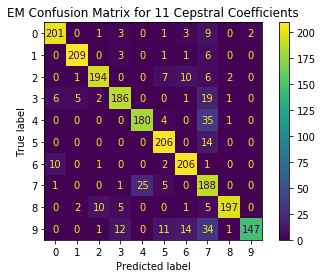

In [247]:
'''
Expectation-Maximization Approach
'''
# obtaining distribution
gmms_em = EM_GMMDigits(clusters_em, final_train_dict)
all_em_gmm = gmms_em.all_gmm()
# maximum likelihood calculation and classification
classifier = ClassifierScorer(final_test_dict, test_data_breakdown, gmms_em)
classifier.all_expected_calc()
classifier.all_predictions_calc()
# model performance evaluation
model_performance_em = {}
dict_accuracy = classifier.get_model_accuracies()
model_performance_em.update(dict_accuracy)
classifier.confusion_mat(num_coeffs)

In [248]:
all_em_gmm

{0: GaussianMixture(n_components=4),
 1: GaussianMixture(n_components=6),
 2: GaussianMixture(n_components=6),
 3: GaussianMixture(n_components=8),
 4: GaussianMixture(n_components=6),
 5: GaussianMixture(n_components=5),
 6: GaussianMixture(n_components=4),
 7: GaussianMixture(n_components=5),
 8: GaussianMixture(n_components=8),
 9: GaussianMixture(n_components=4)}

In [249]:
model_performance_em

{11: [0.9136363636363637,
  0.95,
  0.8818181818181818,
  0.8454545454545455,
  0.8181818181818182,
  0.9363636363636364,
  0.9363636363636364,
  0.8545454545454545,
  0.8954545454545455,
  0.6681818181818182]}

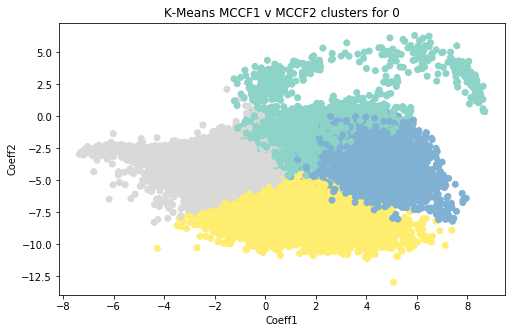

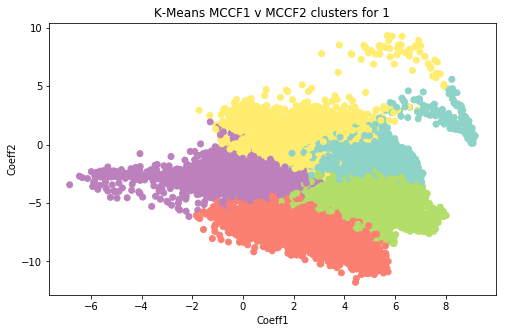

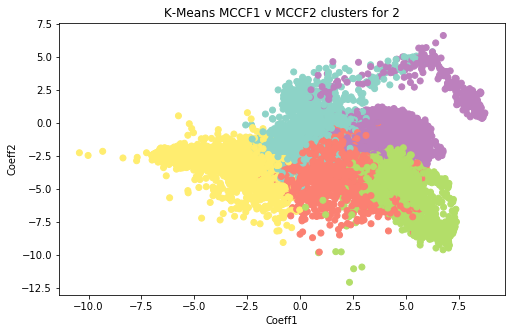

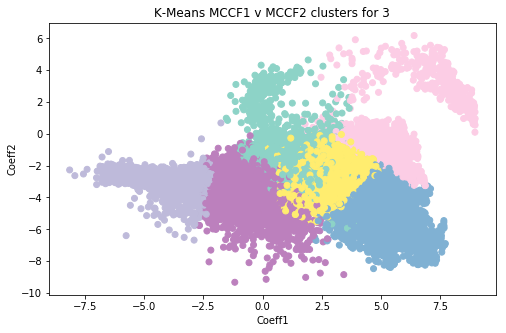

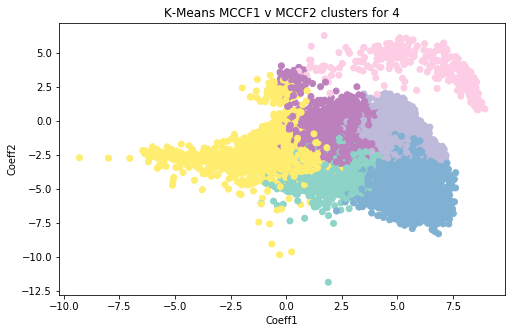

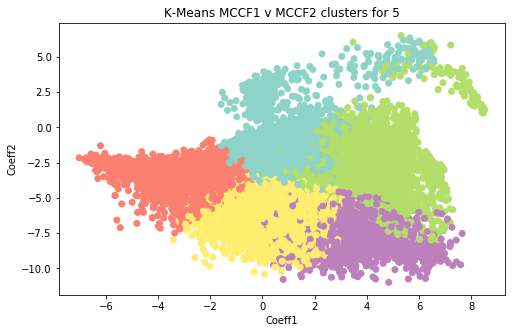

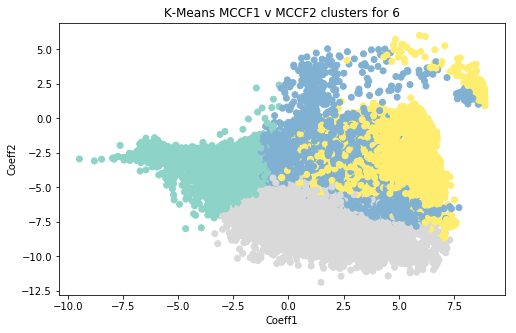

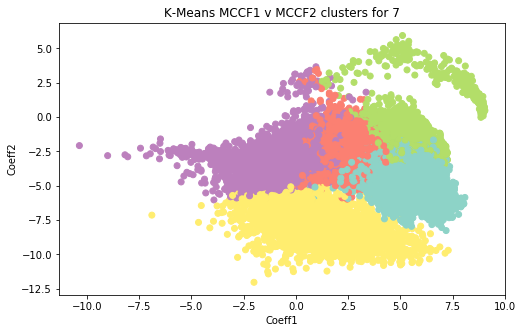

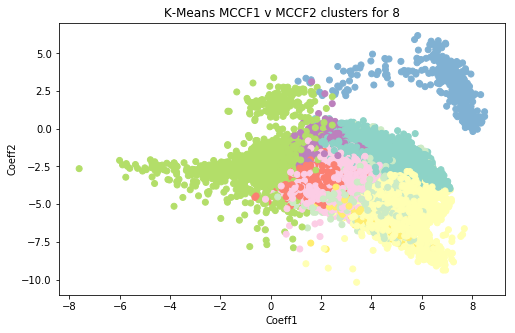

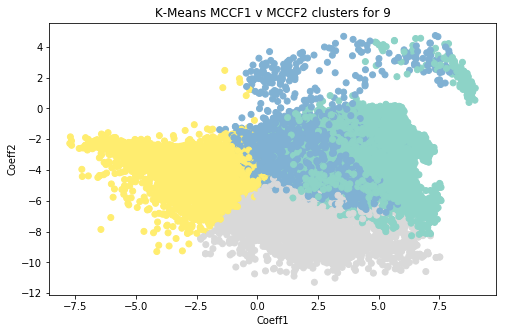

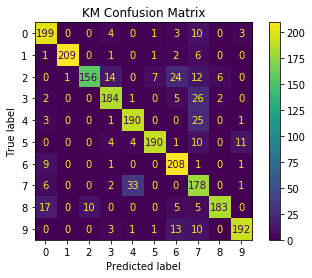

In [252]:
'''
K-Means Clustering Approach
'''
#obtain all digit distributions
gmms_km = KM_GMMDigits(clusters_km, final_train_dict)
all_km_gmm = gmms_km.all_kmeans()
#maximum likelihood calculations and classification
classifier_km = ClassifierScorerKM(final_test_dict, test_data_breakdown, gmms_km)
classifier_km.all_expected_calc()
classifier_km.all_predictions_calc()
#model performance analyses
model_performance_km = {}
dict_accuracy_km = classifier_km.get_model_accuracies()
model_performance_km.update(dict_accuracy_km)
classifier_km.confusion_mat(num_coeffs)

In [255]:
model_performance_km

{11: [0.9045454545454545,
  0.95,
  0.7090909090909091,
  0.8363636363636363,
  0.8636363636363636,
  0.8636363636363636,
  0.9454545454545454,
  0.8090909090909091,
  0.8318181818181818,
  0.8727272727272727]}

For n_clusters = 8 The average silhouette_score is : 0.05096174678935425


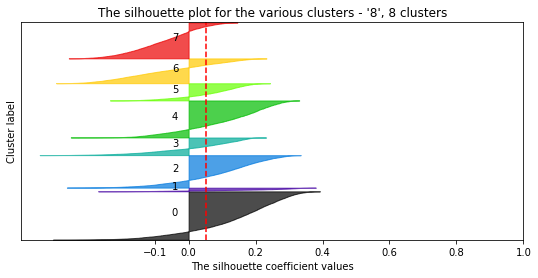

In [263]:
d = 8
X = new_train_dict[d]
digit_sil_coefs = {}
n_clusters = 8

# Create a subplot with 1 row and 2 columns
fig, ax1 = plt.subplots()
fig.set_size_inches(9,4)
ax1.set_xlim([-0.5, 0.8])
ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

# Initialize the clusterer with n_clusters value
clusterer = GaussianMixture(n_components=n_clusters)
clusterer.fit(X)
cluster_labels=clusterer.predict(X)
cluster_labels.shape

# The silhouette_score gives the average value for all the samples.
silhouette_avg = silhouette_score(X, cluster_labels)
digit_sil_coefs[n_clusters] = silhouette_avg

print("For n_clusters =", n_clusters,
      "The average silhouette_score is :", silhouette_avg)

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(X, cluster_labels)

y_lower = 10
for i in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = \
        sample_silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_cluster_silhouette_values,
        facecolor=color,
        edgecolor=color,
        alpha=0.7,
    )

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10 
title = "The silhouette plot for the various clusters - '"+str(d)+"', "+str(n_clusters)+" clusters"
ax1.set_title(title)
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.show()